# NA 568 Mobile Robotics: Methods \& Algorithms Winter 2021 -- Homework 2 -- Kalman Filtering

University of Michigan\
January 25, 2021

## Task 4 First-Order Covariance Propagation (25 points)

In most SLAM approaches, the noise characteristics of individual observations are linearized, resulting in a Gaussian covariance matrix. In this task, we explore the effects of the error introduced via linearization.

Consider a robot sensor that observes range and bearing to nearby landmarks. In this case, the range error is relatively small, but the bearing error is large. We are interested in determining the $(x, y)$ position of the beacon based on observations obtained by the robot at the origin $(0, 0)$. For this problem, the robot does not move.

Suppose you obtain a (range, bearing) observation with mean ($10.0$ m, $0$ rad) whose range standard deviation is $0.5$ m, and whose bearing standard deviation is $0.25$ rad. The range and bearing measurements are Gaussian and independent.

### A. (4 pts) 
Generate a point cloud representing 10,000 samples from the distribution over the position of the beacon as measured in\
  i) the sensor frame, i.e. $(r, \theta)$ space and\
  ii) the Cartesian $(x, y)$ coordinate frame.

In other words, generate observations of (range, bearing) and project these points into $(x,y)$. (Hint: use the *numpy.random.randn()* or *numpy.random.multivariate_normal()* function, and recall that you can sample from a univariate Gaussian with mean *mu* and standard deviation *sigma* with *mu + sigma* \* *randn*.)

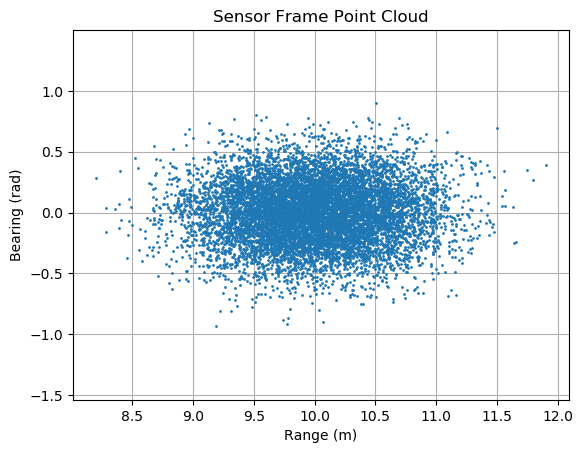

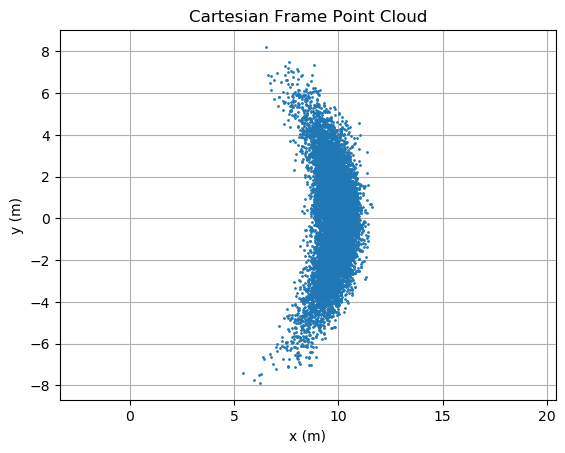

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# parameter setting
N = 10000
mu_sensor = [10, 0]
sigma_sensor = [0.5, 0.25]

# generate point clouds
r, theta = np.zeros(10), np.zeros(10)
x, y = np.zeros(10), np.zeros(10)
#############################################################################
#                    TODO: Implement your code here                         #
#############################################################################
# i) Sensor (r, theta) frame 

r = sigma_sensor[0] * np.random.randn(N) + mu_sensor[0]
theta = sigma_sensor[1] * np.random.randn(N) + mu_sensor[1]
# ii) Cartesian (x,y) coordinate frame
x = r*np.cos(theta)
y = r*np.sin(theta)

#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
# i) Observation in the sensor frame
plt.plot(r, theta, '.', markersize=2)
plt.axis('equal')
plt.grid(True)
plt.title('Sensor Frame Point Cloud')
plt.xlabel('Range (m)')
plt.ylabel('Bearing (rad)')
plt.show()

# ii) Observation in the Cartesian frame
plt.plot(x, y, '.', markersize=2)
plt.axis('equal')
plt.grid(True)
plt.title('Cartesian Frame Point Cloud')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

### B. (4 pts)
What is the (linearized) covariance of the beacon position in $(x, y)$ coordinates? In other words,   write the covariance of an observation in $(x,y)$ coordinates in terms of the covariance of the   observation in (range, bearing) coordinates. The transformation is non-linear, so you will need to compute a first-order approximation (Taylor expansion) of the transformation function. Make the   appropriate Jacobians easy to read in your source code, using comments if necessary.

In [2]:
Jacobian = np.zeros((2,2))
cov_cartesian = np.zeros((2,2))
#############################################################################
#                    TODO: Implement your code here                         #
#############################################################################
# Implement the Jacobians

Jacobian = np.array([[np.cos(mu_sensor[1]), -1*mu_sensor[0]*np.sin(mu_sensor[1])], 
                     [np.sin(mu_sensor[1]), mu_sensor[0]*np.cos(mu_sensor[1])]]
                     )

# Implement the linearized covariance in cartesian corridinates

cov = np.array([[sigma_sensor[0]**2, 0],
               [0, sigma_sensor[1]**2]]
               )

cov_cartesian = Jacobian * cov * Jacobian.T

#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
print('Jacobian:\n', Jacobian)
print('\nSigma_cartesian:\n', cov_cartesian)

Jacobian:
 [[ 1. -0.]
 [ 0. 10.]]

Sigma_cartesian:
 [[ 0.25 -0.  ]
 [-0.    6.25]]


### C. (4 pts)
Draw in red the 1-sigma, 2-sigma, and 3-sigma contours of the analytical (linearized) covariance ellipses, super-imposed over the point clouds generated in parts A.i and A.ii.  Now overlay in blue   the actual covariance ellipses computed using sample-based expressions for the first and second moments.  Do they agree?  Why or why not?

You may use the function *draw\_ellipse()* provided bellow.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def calculateEllipseXY(mu, Sigma, k2, N=20):
    """
    input:
    mu     is the [2x1] [x;y] mean vector
    Sigma  is the [2x2] covariance matrix
    k2     is the Chi-squared 2 DOF variable
    N      is the number of points to use (optional, default 20)
    
    output:
    x and y coordinates to draw the ellipse
    """
    # set up angles for drawing the ellipse
    angles = np.linspace(0, 2*np.pi, num=N)
    _circle = np.array([np.cos(angles), np.sin(angles)])

    # make sure it is a numpy array
    mu = np.array(mu)
    Sigma = np.array(Sigma)
        
    # cholesky decomposition
    L = np.linalg.cholesky(Sigma) # Cholesky factor of covariance
    
    # apply the transformation and scale of the covariance
    ellipse = np.sqrt(k2) * L @ _circle

    # shift origin to the mean
    x = mu[0] + ellipse[0, :].T
    y = mu[1] + ellipse[1, :].T

    return x, y

def draw_ellipse(mu, Sigma, k2, colorin='red'):
    """   
    input:
    mu       is the [2x1] [x;y] mean vector
    Sigma    is the [2x2] covariance matrix
    k2       is the Chi-squared 2 DOF variable
    Npoints  number of points to draw the ellipse (default 20)
    colorin  color for plotting ellipses, red for analytical contours, blue for sample contours
    
    --- h = draw_ellipse(mu, Sigma, k2)
    Draws an ellipse centered at mu with covariance Sigma and confidence region k2, i.e.,
    K2 = 1; # 1-sigma
    K2 = 4; # 2-sigma
    K2 = 9; # 3-sigma
    K2 = chi2inv(.50, 2); # 50% probability contour
    """
    Npoints = 20
    
    x, y = calculateEllipseXY(mu, Sigma, k2, Npoints)
    
    if k2 == 9:
        if colorin == 'red':
            plt.plot(x, y, linewidth=1.25, color=colorin, label='analytical contours')
        elif colorin == 'blue':
            plt.plot(x, y, linewidth=1.25, color=colorin, label='sample contours')
    else:
        plt.plot(x, y, linewidth=1.25, color=colorin)

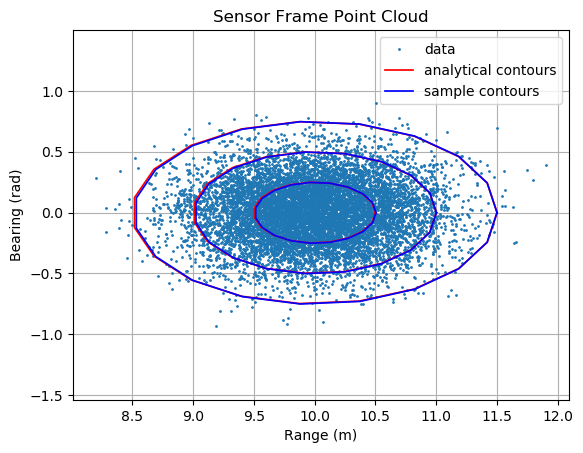

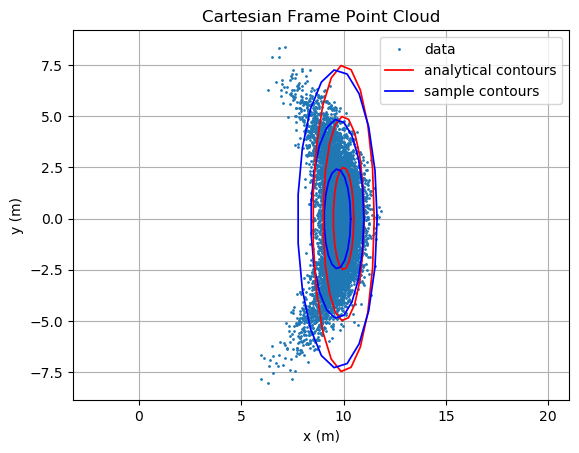

In [4]:
# Sensor frame
plt.plot(r, theta, '.', markersize=2, label='data')
plt.axis('equal')
plt.grid(True)
plt.title('Sensor Frame Point Cloud')
plt.xlabel('Range (m)')
plt.ylabel('Bearing (rad)')
plt.legend()


# parameter setting
N = 10000

# compute the mean and covariance of samples in the sensor frame 
mu_sensor = np.array([10, 0])
sigma_sensor = [0.5, 0.25]
cov_sensor = np.array([[0.5**2, 0],
                          [0, 0.25**2]])

r = sigma_sensor[0] * np.random.randn(N) + mu_sensor[0]
theta = sigma_sensor[1] * np.random.randn(N) + mu_sensor[1]
# ii) Cartesian (x,y) coordinate frame
x = r*np.cos(theta)
y = r*np.sin(theta)


#############################################################################
#                    TODO: Implement your code here                         #
#############################################################################

mu_sensor_sample = np.array(np.mean([r, theta], axis=-1))
cov_sensor_sample = np.array(np.cov([r, theta]))

#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

# plot the ellipses
for i in range(3):
    # analytical contous in red
    draw_ellipse(mu_sensor, cov_sensor, (i+1)**2, 'red')
    # sample contous in blue
    draw_ellipse(mu_sensor_sample, cov_sensor_sample, (i+1)**2, 'blue')

plt.legend()
plt.show()

# Cartesian frame
plt.plot(x, y, '.', markersize=2, label='data')
plt.axis('equal')
plt.grid(True)
plt.title('Cartesian Frame Point Cloud')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# compute the mean and covariance of samples in the Cartesian frame
mu_cartesian = np.zeros((2,))
cov_cartesian = np.zeros((2,2))
mu_cartesian_sample = np.zeros((2,))
cov_cartesian_sample = np.zeros((2,2))
#############################################################################
#                    TODO: Implement your code here                         #
#############################################################################

mu_cartesian = np.array([mu_sensor[0]*np.cos(mu_sensor[1]),
                         mu_sensor[0]*np.sin(mu_sensor[1])
                         ]) 
cov_cartesian = Jacobian * cov * Jacobian.T

mu_cartesian_sample = np.array(np.mean([x, y], axis=-1))
cov_cartesian_sample = np.array(np.cov([x, y]))


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

# plot the ellipses
for i in range(3):
    # analytical contous in red
    draw_ellipse(mu_cartesian, cov_cartesian, (i+1)**2, 'red')    
    # sample contous in blue
    draw_ellipse(mu_cartesian_sample, cov_cartesian_sample, (i+1)**2, 'blue')

plt.legend()
plt.show()

### D. (4 pts)
From a purely theoretical perspective, assuming that the underlying process is truly Gaussian, we expect 39.35% of all samples to lie within the 1-sigma contour, 86.47\% of samples to lie within the 2-sigma contour, and 98.89% to lie within the 3-sigma contour. (These frequencies were computed using the cumulative chi-square distribution for two degrees-of-freedom)

Modify your software to count the samples falling within each (analytical) ellipse for parts A.i   and A.ii. The error of a particular sample $x$, measured in "units" of sigma, is known as the Mahalanobis distance, and can be computed as $\sqrt{(x-\mu)^\top\Sigma^{-1}(x-\mu)}$.

In [5]:
from numpy.linalg import inv

# counter for samples lie within the contour
count_sensor = np.zeros((3,1)) # count results of samples in the sensor frame
count_cartesian = np.zeros((3,1)) # count results of samples in the Cartesian frame

# Compute the Mahalabobis distance of samples, and count how many samples lie in the contour
#############################################################################
#                    TODO: Implement your code here                         #
#############################################################################

def Mahalanobis_dis(x, mu, Sigma):

    diff = x-mu
    return np.sqrt(np.sum(np.multiply(diff @ inv(Sigma), diff), axis=-1))

sensor_vector = np.transpose(np.array([r, theta]))
distance_in_sensor = Mahalanobis_dis(sensor_vector, mu_sensor, cov_sensor)


cartesian_vector = np.transpose(np.array([x, y]))
distance_in_cartesian = Mahalanobis_dis(cartesian_vector, mu_cartesian, cov_cartesian)


# the 3 sigma distance = 1, 2, 3 of Mahalanobis distance
for dis in distance_in_sensor:
    if dis <= 1:
        count_sensor[0][0] += 1
    if dis <= 2:
        count_sensor[1][0] += 1
    if dis <= 3:
        count_sensor[2][0] += 1

for dis in distance_in_cartesian:
    if dis <= 1:
        count_cartesian[0][0] += 1
    if dis <= 2:
        count_cartesian[1][0] += 1
    if dis <= 3:
        count_cartesian[2][0] += 1

#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

# print out the result
Gaussian = [0.39, 0.86, 0.99];
print("         Sensor frame  Cartesian frame  Gaussian\n")
for k in range(3):
    print('%d-sigma%10.2f%16.2f%13.2f\n' % (k+1, count_sensor[k]/N, count_cartesian[k]/N, Gaussian[k]))
    


         Sensor frame  Cartesian frame  Gaussian

1-sigma      0.39            0.38         0.39

2-sigma      0.87            0.80         0.86

3-sigma      0.99            0.93         0.99



### F. (5 pts)
Suppose now that the (range, bearing) measurements are *not independent* but instead jointly correlated under the following three scenarios: \
a) $\rho_{{r\theta}}=0.1$, \
b) $\rho_{r\theta}=0.5$, and \
c) $\rho_{r\theta}=0.9$. 

Repeat parts A and C.

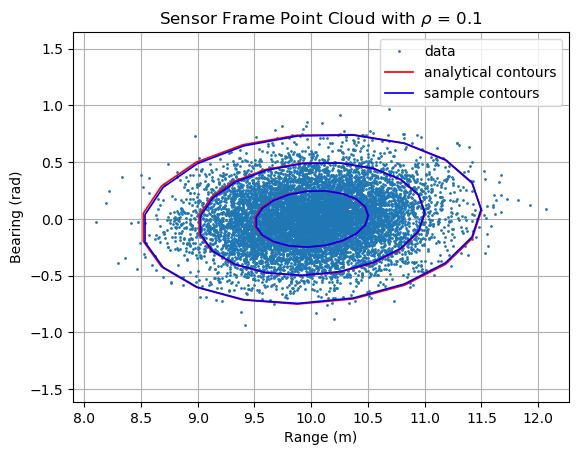

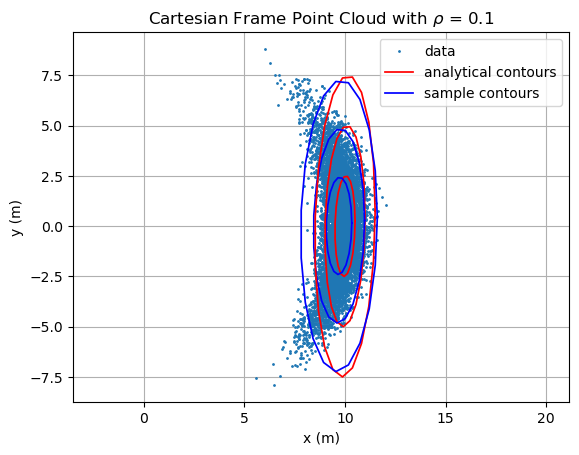

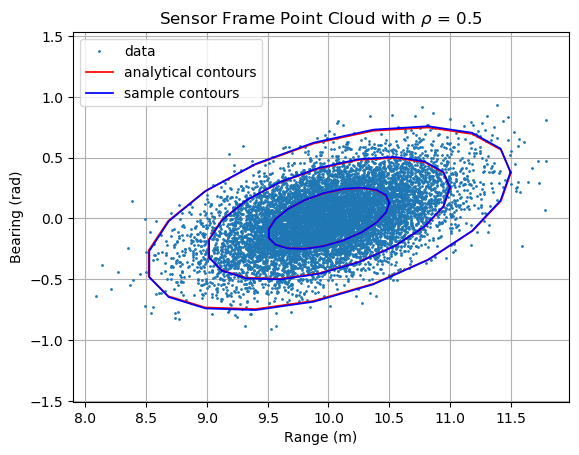

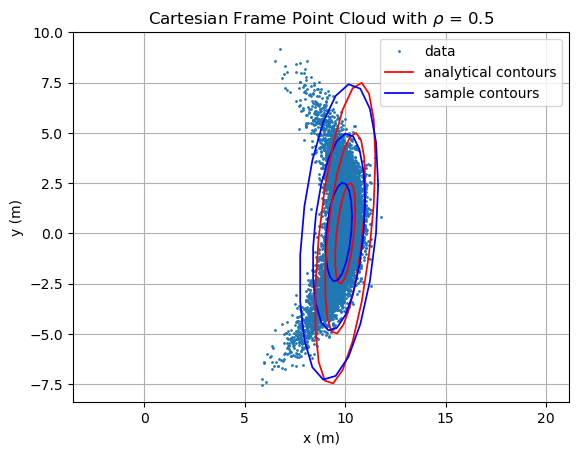

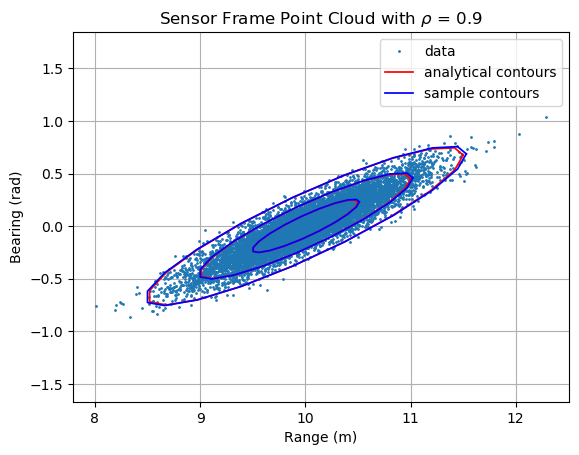

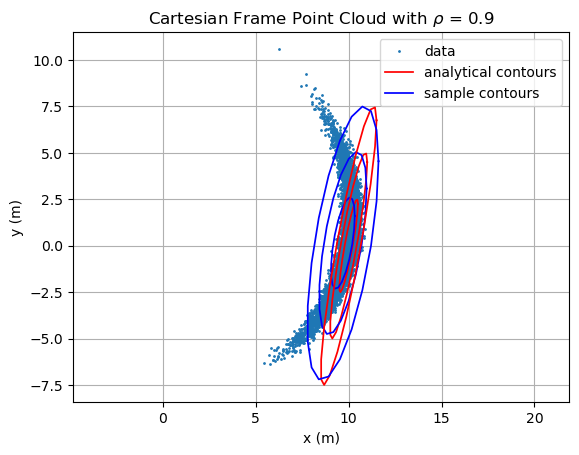

In [6]:
import matplotlib.pyplot as plt


# parameter setting

mu_sensor = [10, 0]
sigma_sensor = [0.5, 0.25]

for rho in [0.1, 0.5, 0.9]: # correlation coefficient, eg. 0.1, 0.5, 0.9
    
    
    #############################################################################
    #                    TODO: Implement your code here                         #
    #############################################################################
    cov_sensor = np.array([
        [sigma_sensor[0]**2, rho*sigma_sensor[0]*sigma_sensor[1]],
        [rho*sigma_sensor[0]*sigma_sensor[1], sigma_sensor[1]**2]
    ])
    # Part A. generate point clouds
    r, theta = np.random.multivariate_normal(mu_sensor, cov_sensor, 10000).T
    x, y = r*np.cos(theta), r*np.sin(theta)
    
    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################
    
    # Part C. Draw ellipse
    # Sensor frame
    plt.plot(r, theta, '.', markersize=2, label='data')
    plt.axis('equal')
    plt.grid(True)
    plt.title(r'Sensor Frame Point Cloud with $\rho$ = %.1f' % rho)
    plt.xlabel('Range (m)')
    plt.ylabel('Bearing (rad)')
    plt.legend()

    # compute the mean and covariance of samples in the sensor frame 
    mu_sensor_sample = np.array(np.mean([r, theta], axis=-1))
    cov_sensor_sample = np.array(np.cov([r, theta]))
    #############################################################################
    #                    TODO: Implement your code here                         #
    #############################################################################
    
    
    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    # plot the ellipses
    for i in range(3):
        # analytical contous in red
        draw_ellipse(mu_sensor, cov_sensor, (i+1)**2, 'red')
        # sample contous in blue
        draw_ellipse(mu_sensor_sample, cov_sensor_sample, (i+1)**2, 'blue')

    plt.legend()
    plt.show()

    # Cartesian frame
    plt.plot(x, y, '.', markersize=2, label='data')
    plt.axis('equal')
    plt.grid(True)
    plt.title(r'Cartesian Frame Point Cloud with $\rho$ = %.1f' % rho)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

    # compute the mean and covariance of samples in the Cartesian frame
    mu_cartesian = np.zeros((2,))
    cov_cartesian = np.zeros((2,2))
    mu_cartesian_sample = np.zeros((2,))
    cov_cartesian_sample = np.zeros((2,2))
    #############################################################################
    #                    TODO: Implement your code here                         #
    #############################################################################
    

    Jacobian = np.array([[np.cos(mu_sensor[1]), -1*mu_sensor[0]*np.sin(mu_sensor[1])], 
                     [np.sin(mu_sensor[1]), mu_sensor[0]*np.cos(mu_sensor[1])]]
                     )
    
    mu_cartesian = np.array([mu_sensor[0]*np.cos(mu_sensor[1]),
                             mu_sensor[0]*np.sin(mu_sensor[1])]) 
    cov_cartesian = Jacobian @ cov_sensor @ Jacobian.T
    
    mu_cartesian_sample = np.array(np.mean([x, y], axis=-1))
    cov_cartesian_sample = np.array(np.cov([x, y]))
    
    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    # plot the ellipses
    for i in range(3):
        # analytical contous in red
        draw_ellipse(mu_cartesian, cov_cartesian, (i+1)**2, 'red')    
        # sample contous in blue
        draw_ellipse(mu_cartesian_sample, cov_cartesian_sample, (i+1)**2, 'blue')

    plt.legend()
    plt.show()